<a href="https://colab.research.google.com/github/FinOloughlin/CITS4403-Black-Death/blob/main/Copy_of_Black_Death.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np

In [4]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

Downloaded utils.py
Downloaded Cell2D.py


In [5]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

In [6]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.7.5-py3-none-any.whl size=12469 sha256=dfe4fe3639e1da516310fea7235b6cd1d9c9b613615bea2709aa7395ef5d351b
  Stored in directory: /root/.cache/pip/wheels/0d/d0/ae/1ad4c7593703e55b2321b23b49d3b0d55261b59d7036d7045b
Successfully built empiricaldist


### !! Mesa documentation: https://mesa.readthedocs.io/stable/

In [7]:
!pip install mesa

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.2 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.7/425.7 kB 13.7 MB/s eta 0:00

# Black Death

In [27]:
class PlagueAgent(Agent):
  """
  An agent representing a person in a simulated bubonic plague scenario.

  Attributes:
    unique_id: Unique identifier for the agent.
    model: Reference to the model in which the agent participates.
    health_status: Current health status of the agent ("Susceptible", "Infected", "Recovered", "Dead").
    age: Age of the agent, randomly assigned between 1 and 80.
    days_infected: Number of days the agent has been infected.
    recovered: Whether the agent has recovered from the infection.
    dead: Whether the agent has died from the infection.
    seeking_treatment: Whether the agent is seeking medical treatment.
  """
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.health_status = "Susceptible"
    self.age = self.random.randrange(1,80)
    self.days_infected = 0
    self.recovered = False
    self.dead = False
    self.seeking_treatment = False

  def step(self):
    self.try_random_infection()

    # If infected update the number of days infected
    if self.health_status == "Infected":
      self.days_infected += 1
      # After 4 days, check if the agent recovers or dies
      if self.days_infected >= 4:
        self.check_recovery_or_death()

      # If agent is infected, they will start seeking treatment
      self.seeking_treatment = True

      if self.seeking_treatment:
        self.move_to_doctor() # Move towards doctor's office for treatment

      if self.is_near_doctor_office():
        self.try_to_get_cured

      # Spread the disease to nearby agents
      self.spread_disease()

    # Move the agent to a random neighbouring cell
    self.move()

  def move_to_doctor(self):
    """
    Move the agent towards the nearest doctor office.
    """
    nearest_office = min(self.model.doctor_offices, key=lambda office: self.distance(office))
    self.move_toward(nearest_office)

  def is_near_doctor_office(self):
    """
    Check if the agent is near a doctor office.
    """
    doctor_office_pos = self.model.doctor_offices
    neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)

    return doctor_office_pos in neighbors


  def try_to_get_cured(self):
    """
    Try to get cured from the disease, when visiting a doctor's office.
    The chance of recovery is 70% when at the office.
    """

    recovery_chance = 0.7

    if self.random.random() < recovery_chance:
        self.recovered = True
        self.health_status = "Recovered"
        self.seeking_treatment = False

  def move_toward(self, destination):
    """
    Move the agent towards a specific destinatio e.g. doctor's office.

    Parameters:
    - destination: Tuple representing the (x, y) coordinates of the destination.
    """
    x, y = self.pos
    target_x, target_y = destination

    dx = target_x - x
    dy = target_y - y

    new_pos = (x + np.sign(dx), y + np.sign(dy))
    self.model.grid.move_agent(self, new_pos)

  def distance(self, target):
    """
    Calculate the distance (Manhattan) between the agent's position and the target.

    Parameters:
    - target: Tuple representing the (x, y) coordinates of the target.

    Returns:
    - Distance between the agent's position and the target.
    """
    x1, y1 = self.pos
    x2, y2 = target
    return abs(x1 - x2) + abs(y1 - y2)


  def spread_disease(self):
    """
    Infecting neighboring agents with a 10% chance.
    """
    infection_chance = 0.1

    neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)

    for neighbor in neighbors:
      if isinstance(neighbor, PlagueAgent) and neighbor.health_status == "Susceptible":
        if self.random.random() < infection_chance:
          neighbor.health_status = "Infected"

  def try_random_infection(self):
    """
    Randomly infect a neighboring agent with a 5% chance, if the agent is susceptible.
    """
    chance = 0.05
    if self.health_status == "Susceptible" and self.random.random() < chance:
      self.health_status = "Infected"

  def check_recovery_or_death(self):
    """
    Check if the agent recovers or dies after being infected.
    The chances of recovery and death depend on the agent's age.
    """

    # Set recovery chances based on age
    if self.age < 30:
      recovery_chance = 0.4
    elif 30 <= self.age <= 50:
      recovery_chance = 0.3
    else:
      recovery_chance = 0.2

    # Set death chances based on age
    if self.age < 30:
      death_chance = 0.4
    elif 30 <= self.age <= 50:
      death_chance = 0.6
    else:
      death_chance = 0.8

    if not self.recovered and not self.dead:
      if self.random.random() < recovery_chance:
        self.recovered = True
        self.health_status = "Recovered"

    if not self.recovered and not self.dead:
      if self.random.random() < death_chance:
        self.dead = True
        self.health_status = "Dead"

  def move(self):
    """
    Move the agent to a random neighbouring cell if the agent is not dead.
    """
    if self.health_status == "Dead":
      return # We return nothing as dead agents do not move

    x, y = self.pos

    # Get all neighbouring cells within bounds
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            new_x = x + dx
            new_y = y + dy
            if 0 <= new_x < self.model.grid.width and 0 <= new_y < self.model.grid.height:
                neighbors.append((new_x, new_y))

    # Move to a random neighbouring cell
    if neighbors:
        new_position = self.random.choice(neighbors)
        self.model.grid.move_agent(self, new_position)


class PlagueModel(Model):
  """
  The model class that manages the simulation, grid and schedule of agents.

  Attributes:
    num_agents: Number of agents in the simulation.
    height: Height of the grid.
    width: Width of the grid.
    grid: A MultiGrid object to represent the grid of simulation.
    schedule: A schedule to manage when each agent's step function is called.
    doctor_offices: A list of tuples representing the positions of doctor offices.
  """
  def __init__(self, width, height, num_agents, num_doctors):
    super().__init__()
    self.num_agents = num_agents
    self.height = height
    self.width = width
    self.grid = MultiGrid(width, height, True)
    self.schedule = RandomActivation(self)
    self.death_count = 0

    # Create agents and doctor's offices
    self.create_agents()
    self.doctor_offices = self.create_doctor_office(num_doctors)

  def create_agents(self):
      """
      Create all agents and place them on the grid, with clustering logic to simulate housing.
      """
      max_neighbours = 3
      max_attempts = 6  # Limit the number of attempts to place an agent
      for i in range(self.num_agents):
          placed = False
          attempts = 0

          while not placed and attempts < max_attempts:
              if i == 0:
                  # Place the first agent at a random location
                  x = self.random.randrange(self.grid.width)
                  y = self.random.randrange(self.grid.height)
              else:
                  # Try placing near an existing agent
                  existing_agent = self.random.choice(self.schedule.agents)
                  x, y = existing_agent.pos

                  # Randomize the placement around the existing agent
                  x = max(0, min(self.grid.width - 1, x + self.random.randint(-1, 1)))
                  y = max(0, min(self.grid.height - 1, y + self.random.randint(-1, 1)))

              # Check actual neighbors on the grid
              neighbors = self.grid.get_neighbors((x, y), moore=True, include_center=False)

              if len(neighbors) <= max_neighbours:
                  placed = True

              attempts += 1

          # If placed successfully, create and place the agent
          if placed:
              agent = PlagueAgent(i, self)
              self.grid.place_agent(agent, (x, y))
              self.schedule.add(agent)
          else:
              # If unable to place within the attempt limit, place at a random location
              x = self.random.randrange(self.grid.width)
              y = self.random.randrange(self.grid.height)
              agent = PlagueAgent(i, self)
              self.grid.place_agent(agent, (x, y))
              self.schedule.add(agent)


  def create_doctor_office(self, num_doctors):
    """
    Create doctor's offices at random locations on the grid.

    Parameters:
    - num_doctors: Number of doctor's offices to create.

    Returns:
    - A list of (x, y) tuples representing the positions of doctor offices.
    """
    doctor_offices = []
    for i in range(num_doctors):
        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)
        doctor_offices.append((x, y))
    return doctor_offices


  def step(self):
    """
    Run one step of the model.
    """
    self.schedule.step()

  def plot_agents(self):
    """
    Using matplotlib we plot the current state of the grid and agents.
    """
    grid = np.zeros((self.grid.height,self.grid.width))

    for cell in self.grid.coord_iter():
      cell_content,(x,y) = cell
      if (x,y) in self.doctor_offices:
        grid[x][y] = 5 # Yellow
      if len(cell_content) > 0:
        agent = cell_content[0]
        if agent.health_status == "Susceptible":
          grid[x][y] = 1 # Blue
        elif agent.health_status == "Infected":
          grid[x][y] = 2 # Red
        elif agent.health_status == "Recovered":
          grid[x][y] = 3 # Green
        elif agent.health_status == "Dead":
          grid[x][y] = 4 # Black

    # Define colours for the plot
    # White is for cells without an agent or doctor's office.
    custom_colours=["white","blue","red","green","black","yellow"]
    cmap = mcolors.ListedColormap(custom_colours)

    # Display the grid with agents
    plt.imshow(grid,cmap=cmap,interpolation='nearest',vmin=0,vmax=5)
    plt.title("Black Plague")
    plt.show()


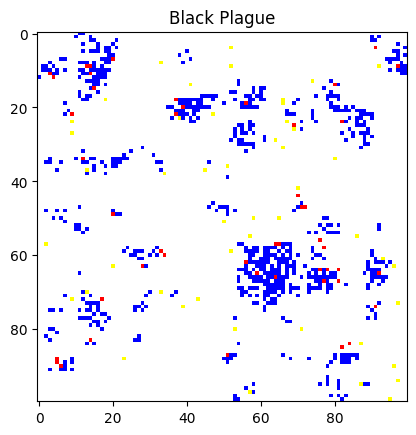

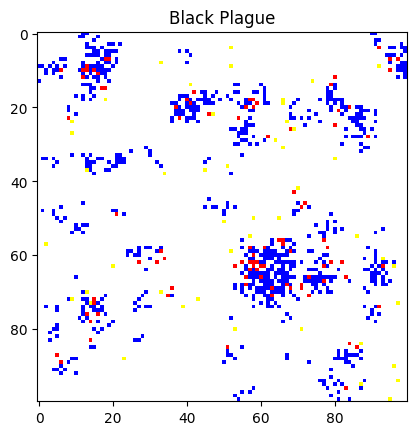

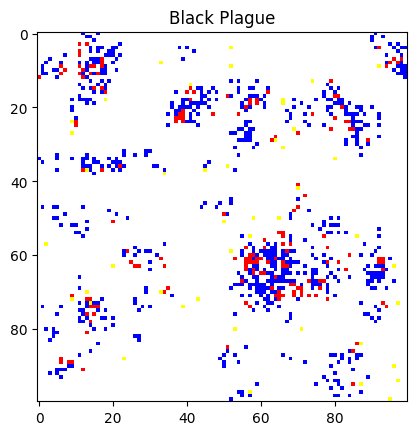

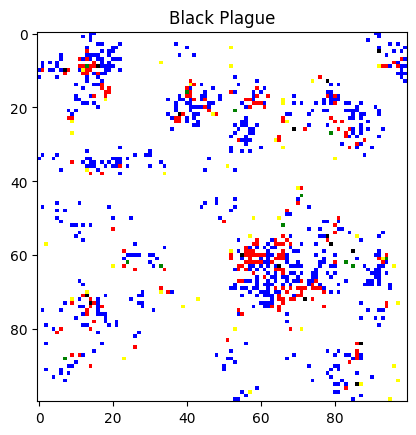

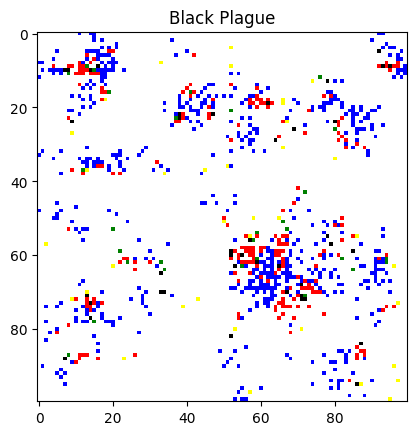

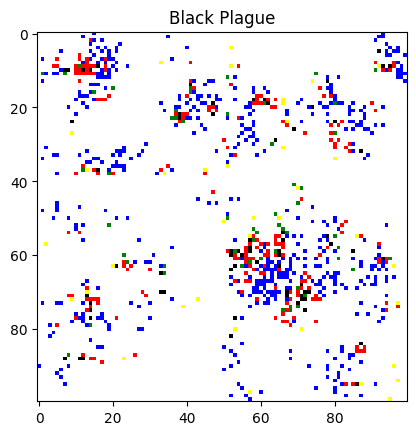

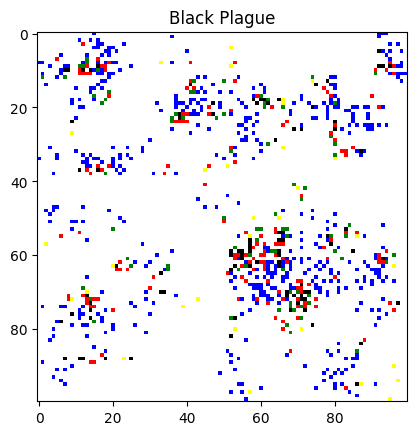

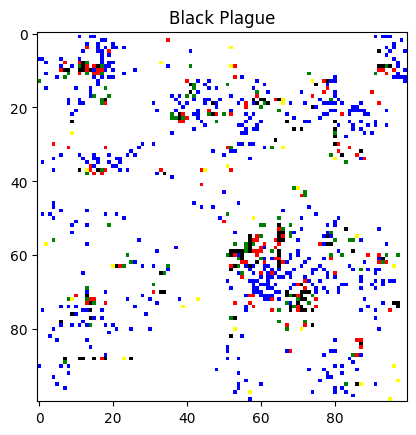

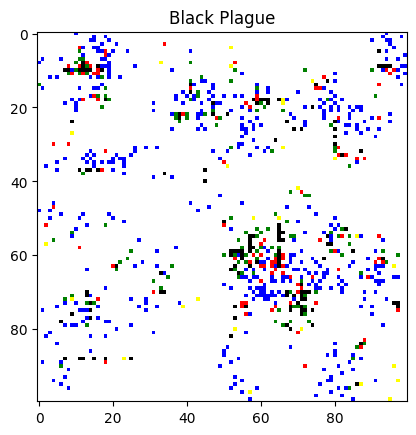

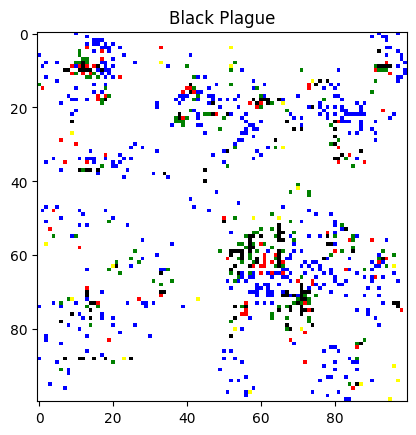

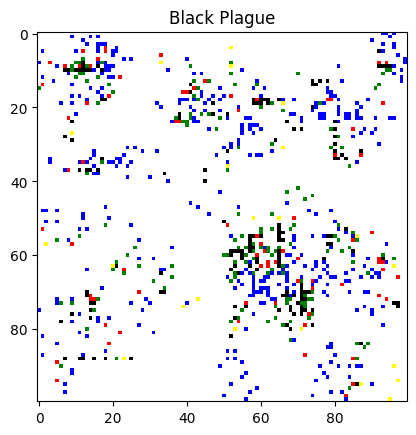

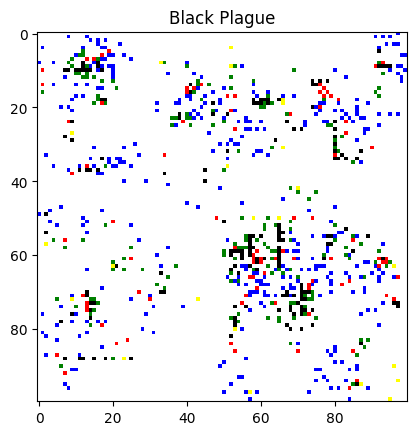

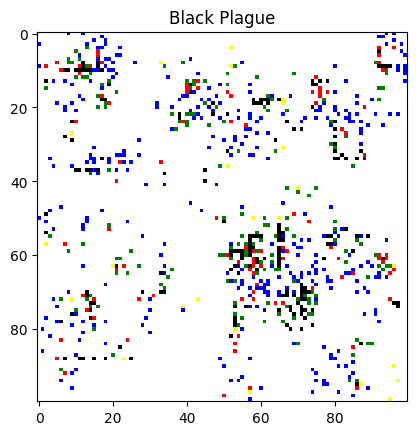

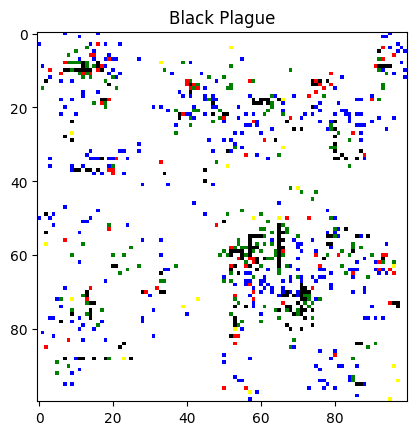

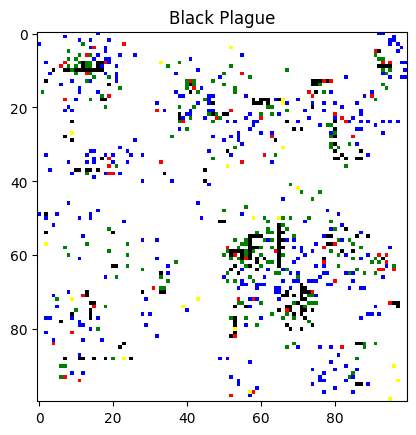

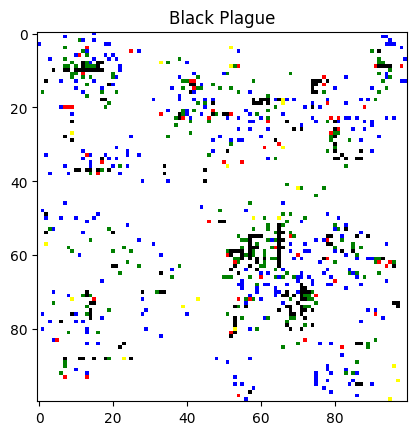

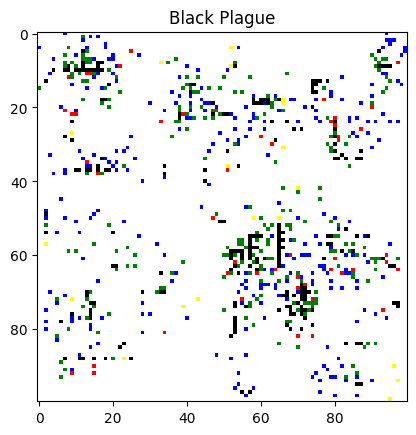

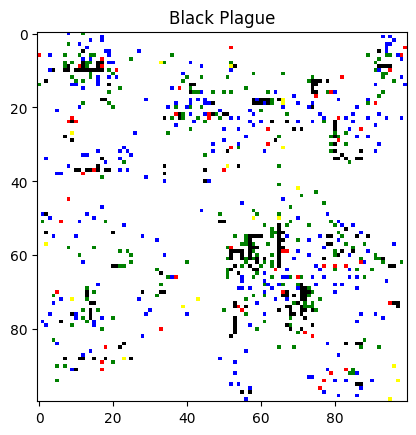

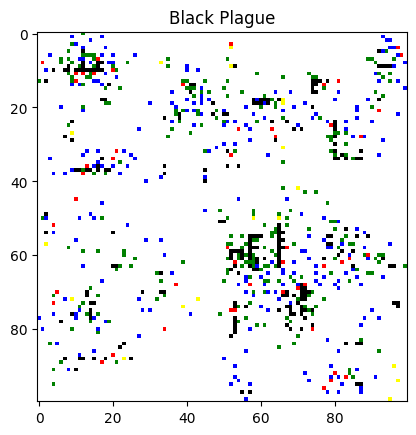

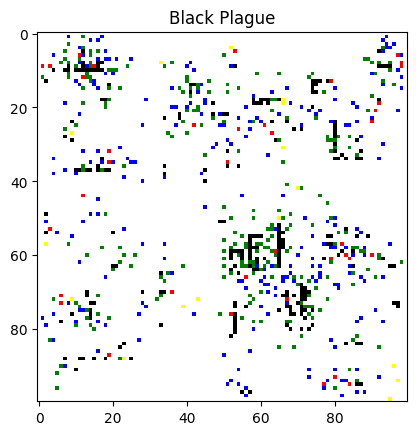

In [29]:
model = PlagueModel(width=100, height=100, num_agents=1000, num_doctors=50)

for i in range(20):
  model.step()
  model.plot_agents()